## Regresión Lineal Regularizada: *Relación entre los recursos sanitarios y los datos socio demográficos en EEUU*

### 1. Análisis Exploratorio de Datos (EDA)

### 1.1. Exploración preliminar de los datos

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [40]:
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv")

In [41]:
pd.set_option('display.max_columns', None)
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.3

In [42]:
df.shape

(3140, 108)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [44]:
print(df.columns[df.isnull().mean() > 0])

Index([], dtype='object')


In [45]:
print(df.columns[df.nunique() == 1])

Index([], dtype='object')


In [46]:
print(df.select_dtypes(include=['object']).columns)

Index(['COUNTY_NAME', 'STATE_NAME'], dtype='object')


In [47]:
df.duplicated().sum()

0

*Conclusiones estudio preliminar:*

- *108 variables, de las cuales elegimos como target relacionado con la salud "R_death_2018", que define la tasa de mortalidad durante el periodo de un año.*
- *3140 filas (personas residentes en EEUU y usuarios del sistema de salud).*
- *No existen valores faltantes, ni duplicados, ni variables con un único valor.*
- *2 únicas variables categóricas: "COUNTY_NAME" Y "STATE_NAME", que transformaremos.*

### 1.2. Exploración de la variable respuesta elegida: tasa de mortalidad

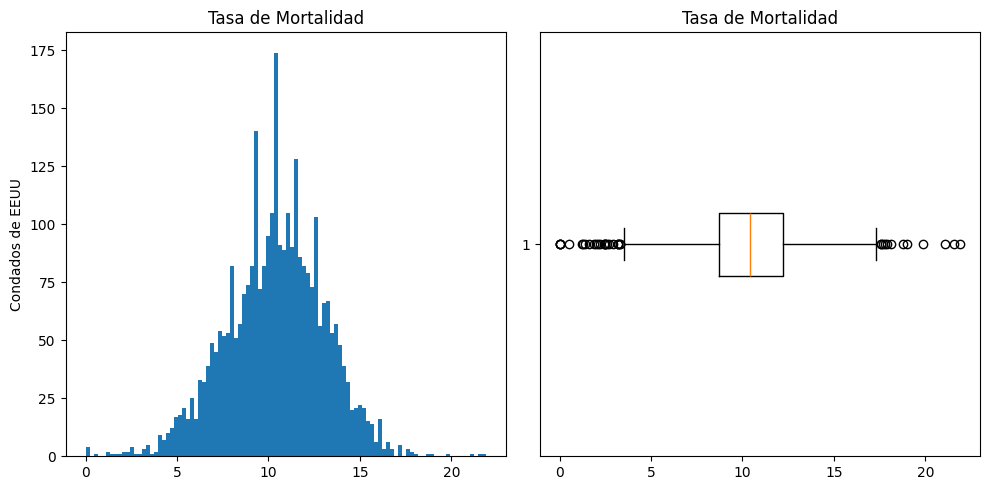

In [57]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].hist(df['R_death_2018'], bins = 100)
ax[0].set_title('Tasa de Mortalidad')
ax[0].set_ylabel('Condados de EEUU')

ax[1].boxplot(df['R_death_2018'], vert = False)
ax[1].set_title('Tasa de Mortalidad')


plt.tight_layout()
plt.show()

*La variable respuesta sigue una distribución normal.*

### 1.3. Análisis univariante: variables categóricas

In [49]:
unique_counts = df[['COUNTY_NAME', 'STATE_NAME']].nunique()
print(unique_counts)

COUNTY_NAME    1841
STATE_NAME       51
dtype: int64


In [50]:
# Codificación de frecuencia para COUNTY_NAME y STATE_NAME
freq_encoding_C = df['COUNTY_NAME'].value_counts().to_dict()
df['COUNTY_NAME'] = df['COUNTY_NAME'].map(freq_encoding_C)

freq_encoding_S = df['STATE_NAME'].value_counts().to_dict()
df['STATE_NAME'] = df['STATE_NAME'].map(freq_encoding_S)


In [51]:
df[['COUNTY_NAME','STATE_NAME']].head()

,COUNTY_NAME,STATE_NAME
0,1,67
1,2,67
2,2,67
3,2,67
4,2,67


### 1.4. Análisis univariante: variables numéricas

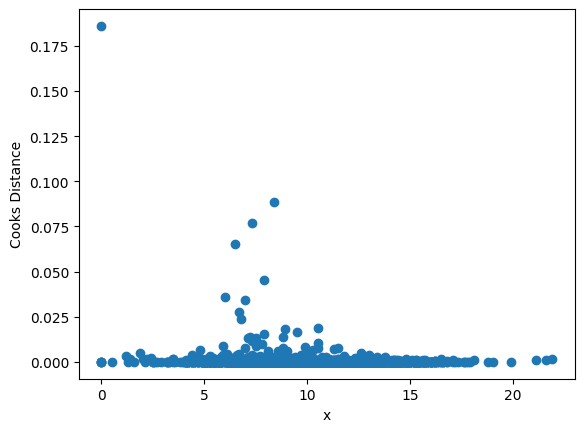

In [52]:
# Intentamos detectar observaciones influyentes mediante la distancia de Cook


X = df.drop(['R_death_2018'], axis = 1)
y = df['R_death_2018']


X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Obtención de la distancia de Cook para cada observación (fila)
cooks_distance = model.get_influence().cooks_distance

plt.scatter(df.R_death_2018, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [53]:
print(np.where(cooks_distance[0]> 0.025))


(array([ 213,  360,  546,  608, 1866, 2535, 2577, 2621]),)


In [54]:
df.drop([202,  213,  360,  546,  608, 1866, 2535, 2577, 2621], axis=0, inplace=True)

In [55]:
# Mostrar las columnas con skew mayor que 7 y sus valores
high_skewed_cols = df.apply(lambda x: x.skew()).loc[lambda x: abs(x) > 7]
print(high_skewed_cols)


0-9                                            7.233336
19-Oct                                         7.148759
20-29                                          7.215218
30-39                                          7.258645
40-49                                          7.016444
White-alone pop                                7.508206
Black-alone pop                                8.830632
Native American/American Indian-alone pop     12.315925
% NA/AI-alone                                  7.558446
Asian-alone pop                               13.634143
% Asian-alone                                  7.011227
Hawaiian/Pacific Islander-alone pop           32.295583
% Hawaiian/PI-alone                           21.032401
Two or more races pop                         11.038332
N_POP_CHG_2018                                11.457626
Less than a high school diploma 2014-18        8.717697
Some college or associate's degree 2014-18     7.577831
POVALL_2018                                    7

In [59]:
# Definimos una función para winsorirar las columnas no binarias
def winsorize(column, lower, upper):
    q1 = column.quantile(lower)
    q3 = column.quantile(upper)
    iqr_value = q3-q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column

# Calcular el IQR y aplicar winsorización a cada columna
for column in high_skewed_cols.columns:
        high_skewed_cols[column] = winsorize(high_skewed_cols[column], 0.25, 0.75) 

AttributeError: 'Series' object has no attribute 'columns'

In [58]:
high_skewed_cols.apply(lambda x: x.skew()) # Ha mejorado el sesgo de las variables numéricas

AttributeError: 'float' object has no attribute 'skew'

In [60]:
df.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,1,67,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,2,67,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.362847,2244,9.018930,10

### 1.5. Análisis multivariante - Selección de características

In [61]:
# Separamos en variables predictoras y variable respuesta
X = df.drop(['R_death_2018'], axis = 1)
y = df['R_death_2018']

In [ ]:
# Separamos en conjunto de entrenamiento y conjunto de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 63)

In [ ]:
# Vamos a usar un método embebido que nos informe de la importancia de las características
# Crea un modelo XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror')

# Entrena el modelo en los datos de entrenamiento
model.fit(X_train, y_train)

# Calcula la importancia de las características
feature_importances = model.feature_importances_

# Asocia las importancias con los nombres de las características
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Ordena las características por importancia (de mayor a menor)
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Imprime la importancia de las características (número adimensional, las características se comparan entre sí en términos de su contribución relativa a la predicción)
for feature, importance in sorted_feature_importance.items():
    print(f'Feature: {feature}, Importance: {importance}')

Feature: R_NATURAL_INC_2018, Importance: 0.41268351674079895
Feature: R_birth_2018, Importance: 0.12198460847139359
Feature: Heart disease_Lower 95% CI, Importance: 0.0974310040473938
Feature: Heart disease_Upper 95% CI, Importance: 0.047207873314619064
Feature: 30-39, Importance: 0.04419557750225067
Feature: % White-alone, Importance: 0.043497033417224884
Feature: Heart disease_prevalence, Importance: 0.03920309245586395
Feature: Obesity_number, Importance: 0.028430670499801636
Feature: Total Hospitals (2019), Importance: 0.023902732878923416
Feature: COPD_Lower 95% CI, Importance: 0.023469585925340652
Feature: COPD_prevalence, Importance: 0.009583187289536
Feature: Percent of adults with a bachelor's degree or higher 2014-18, Importance: 0.008048358373343945
Feature: Two or more races pop, Importance: 0.007344276178628206
Feature: 19-Oct, Importance: 0.006627328228205442
Feature: 80+, Importance: 0.006066081579774618
Feature: COUNTY_NAME, Importance: 0.00582084758207202
Feature: Whit

In [ ]:
important_features = [feature for feature, importance in feature_importance_dict.items() if importance >= 0.001]

In [ ]:
len(important_features)

32

In [ ]:
ds = df[important_features + ['R_death_2018']] 

# Muestra el DataFrame filtrado
ds

,0-9,19-Oct,30-39,30-39 y/o % of total pop,40-49 y/o % of total pop,60-69 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Hawaiian/PI-alone,Two or more races pop,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_NATURAL_INC_2018,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,Total Hospitals (2019),Percent of Population Aged 60+,COUNTY_NAME,anycondition_Lower 95% CI,Obesity_Lower 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,COPD_prevalence,COPD_Lower 95% CI,diabetes_Lower 95% CI,diabetes_number,R_death_2018
0,6787.00,7637,7089.0,12.749771,13.636445,10.478229,2014,3.622237,42660,76.725239,10915,0.111509,1016.00,158.00,455,11.8,2.2,11.3,27.7,1.148905,19.1,1402,45.4,34.2,15193,7.9,7.2,8.7,8.6,7.3,11.9,5462,9.6
1,18156.75,19808,18698.5,11.564429,12.539102,13.728890,9368,4.296814,132954,87.285228,14082,0.066966,3445.75,863.25,2190,10.5,0.1,9.7,31.3,4.505074,26.3,464,38.2,28.4,50761,7.8,7.0,8.7,8.6,7.2,11.0,20520,10.3
2,2732.00,2960,3201.0,12.865239,12.354809,12.362847,1048,4.212049,12209,49.069571,12042,0.184880,307.00,-277.00,2820,10.4,-2.5,27.0,12.2,0.514126,23.5,464,55.6,39.5,8013,11.0,10.1,11.8,12.1,10.7,18.6,3870,12.9
3,2456.00,2596,3113.0,13.897321,13.562500,11.361607,785,3.504464,17211,76.834821,4770,0.116071,242.00,-155.00,2151,11.1,-0.3,16.8,11.5,0.462860,21.1,464,49.6,37.4,6894,8.6,7.9,9.3,10.0,8.8,13.2,2511,11.4
4,7095.00,7570,6884.0,11.901798,12.921853,12.041840,2335,4.036999,55456,95.878285,950,0.121024,801.00,13.00,489,11.8,0.3,19.8,12.6,1.195171,23.6,464,44.3,32.4,15112,9.2,8.4,10.1,10.5,9.1,12.6,6017,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,6104.00,6326,6577.0,15.277229,12.389956,11.481731,949,2.204362,40397,93.835219,592,0.157952,894.00,-496.00,660,12.6,5.6,9.0,22.0,2.160982,15.8,1402,38.5,32.1,10672,5.9,5.4,6.4,6.6,5.7,8.3,2834,7.0
3136,2384.00,2185,4093.0,17.733200,14.830380,12.456133,657,2.846497,21971,95.190850,175,0.151640,363.00,-180.00,270,9.9,6.7,5.6,57.4,1.158570,18.7,258,22.4,18.1,3655,5.2,4.6,5.8,4.9,4.0,6.5,1360,3.2
3137,3121.00,3205,2702.0,13.311001,11.773979,12.581901,507,2.497660,19356,95.354451,168,0.147791,361.00,-157.00,220,13.5,6.3,7.2,15.4,1.018926,17.1,1402,40.0,32.5,4944,7.2,6.5,7.9,8.0,7.0,9.5,1500,7.2
3138,858.00,1113,903.0,11.452124,11.414077,14.178821,452,5.732403,7450,94.483196,40,0.101458,179.00,-150.00,140,9.3,-1.4,10.4,21.5,0.395794,26.7,1402,35.3,27.0,1730,8.2,7.4,9.0,8.3,7.1,10.3,686,10.7


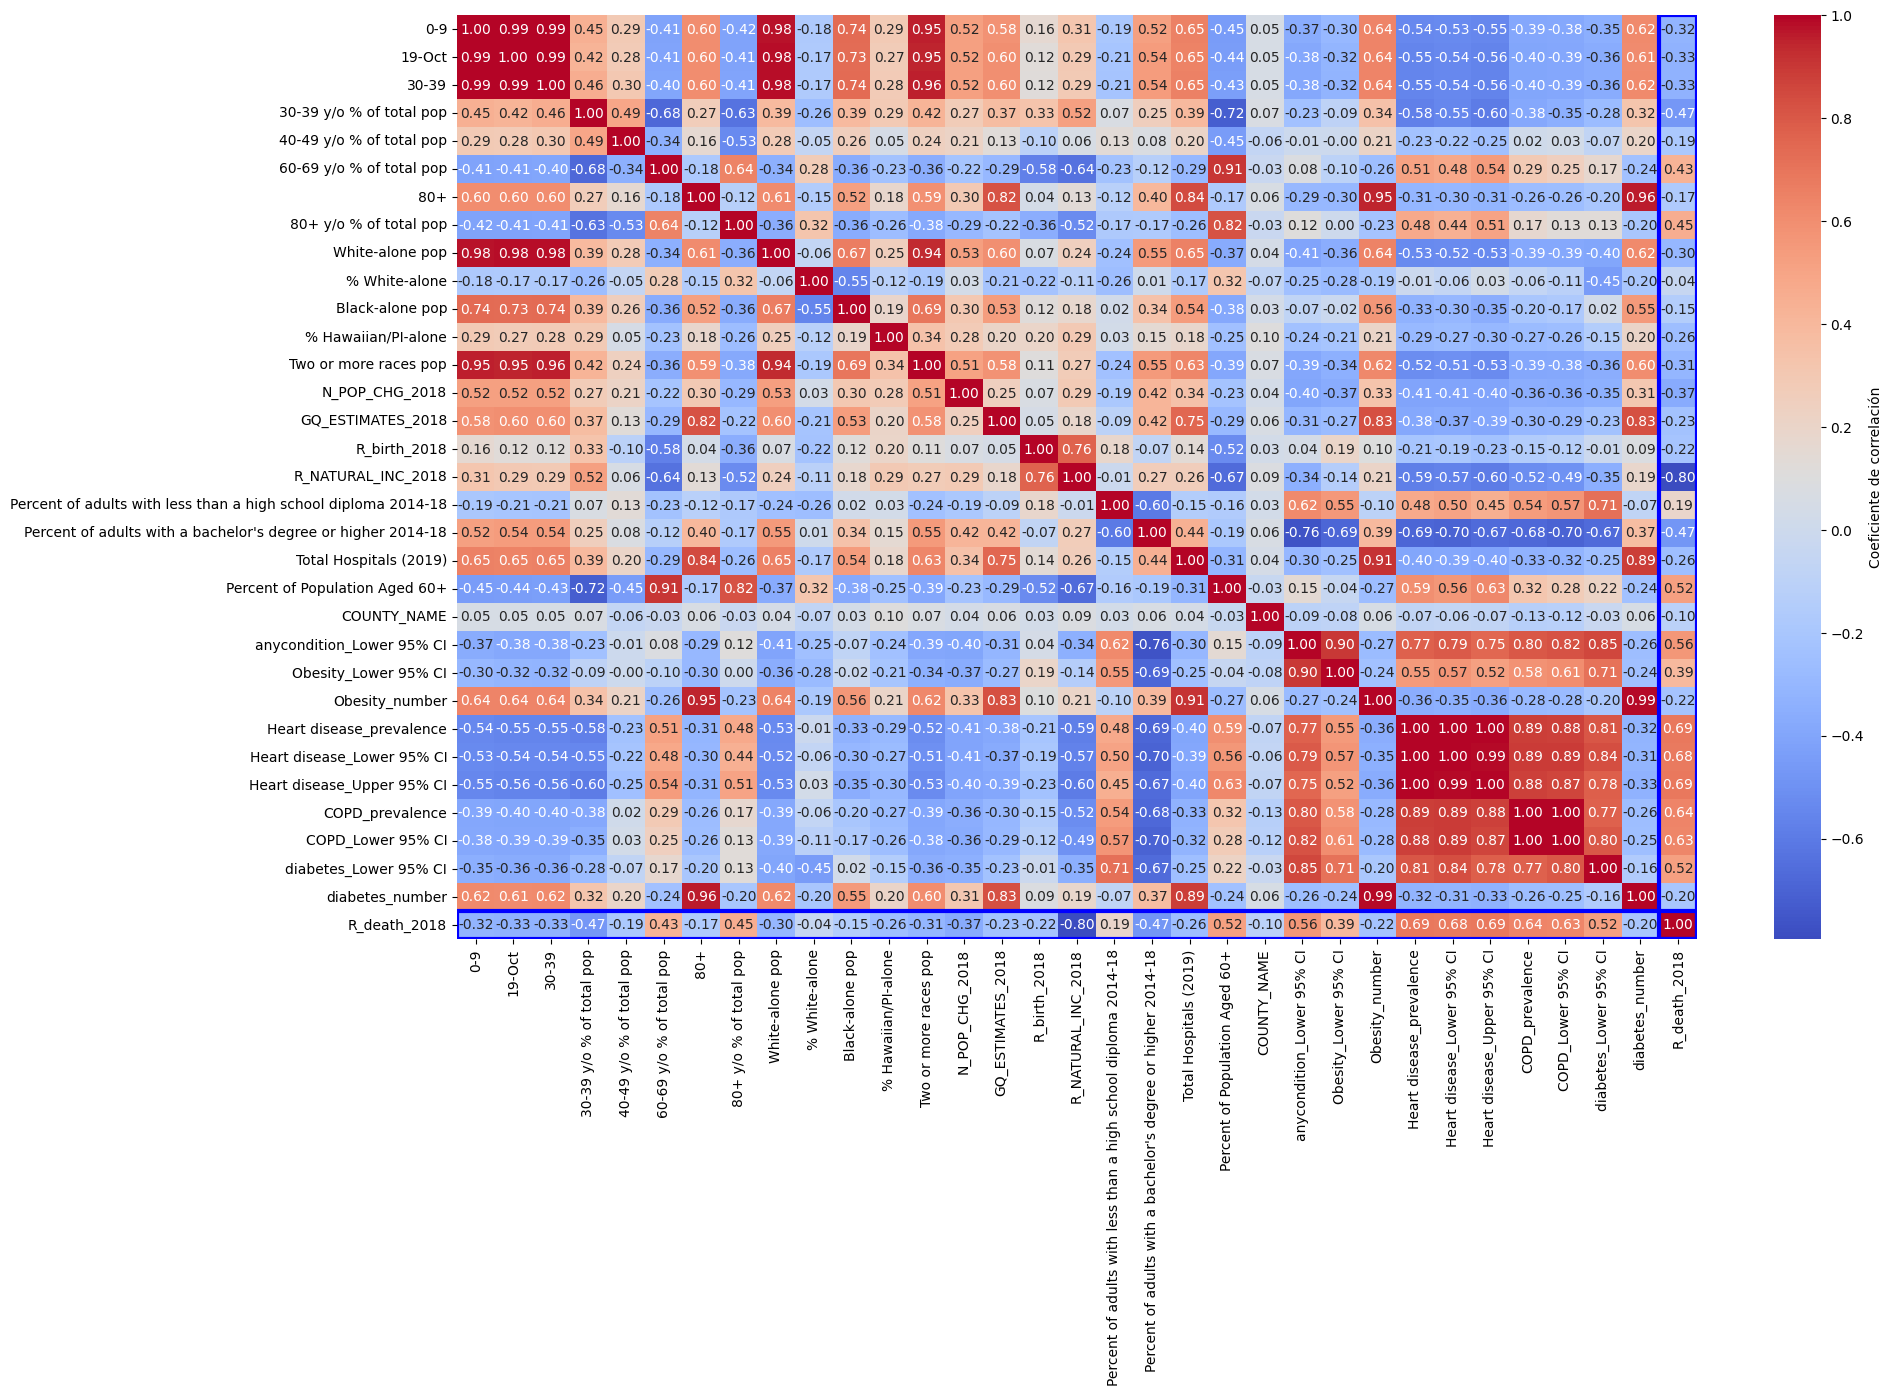

In [ ]:
# Realizamos el gradiente de correlaciones
corr = ds.corr()

def corr_highlighted_target(corr, target):
   
    
    plt.figure(figsize=(20, 12))

    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coeficiente de correlación'})

    target_index = corr.columns.tolist().index(target)

    plt.gca().add_patch(plt.Rectangle((target_index, 0), 1, len(corr), fill=False, edgecolor='blue', lw=3))
    plt.gca().add_patch(plt.Rectangle((0, target_index), len(corr), 1, fill=False, edgecolor='blue', lw=3))

    plt.show()
   


corr_highlighted_target(corr, 'R_death_2018')

In [ ]:
ds = ds.drop(columns=ds.corr().abs()['R_death_2018'][lambda x: x < 0.2].index)

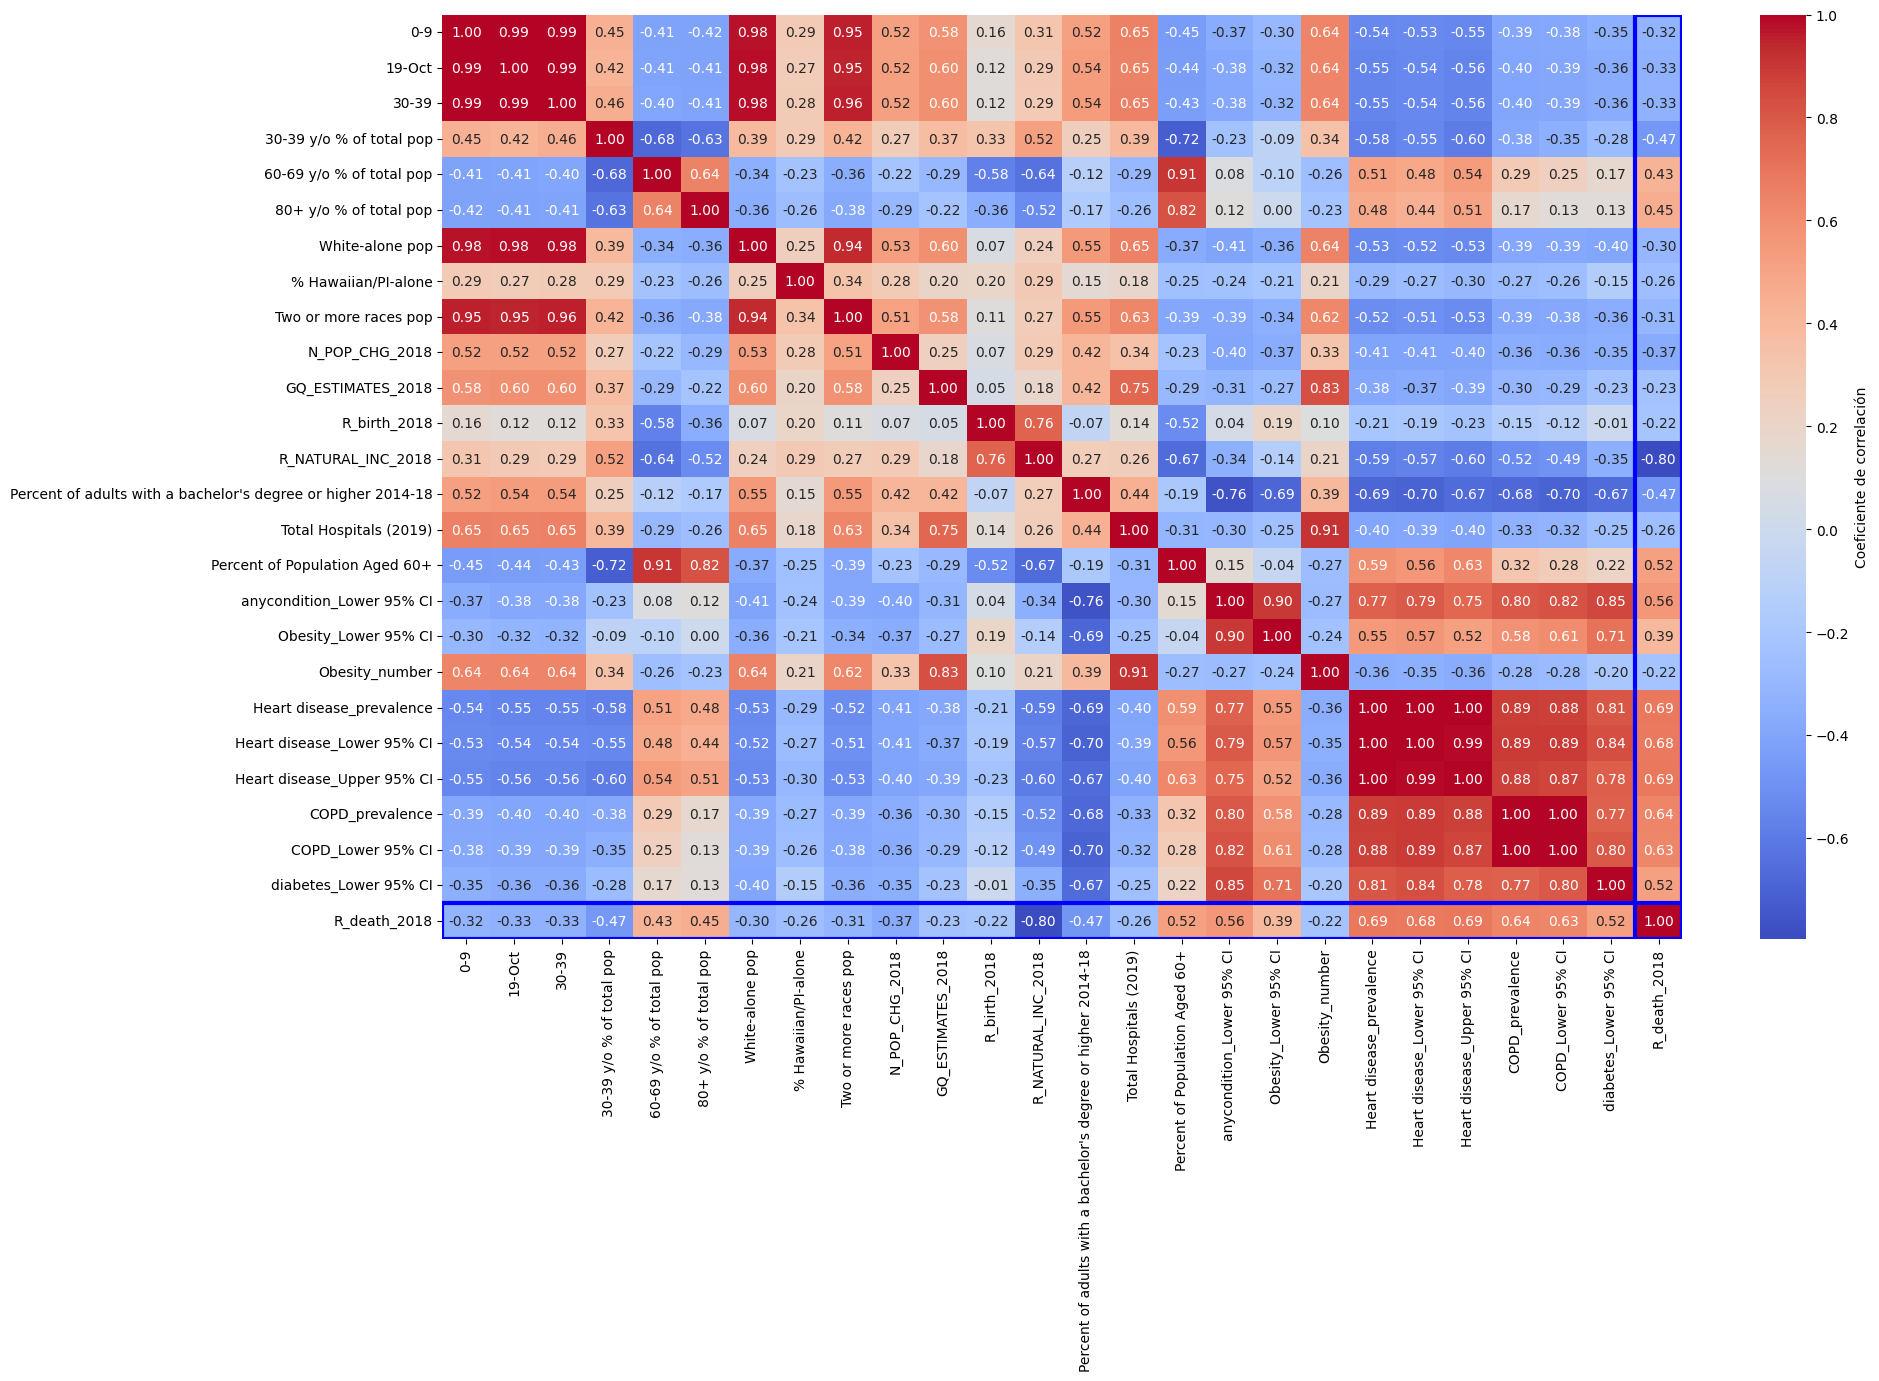

In [ ]:
corr = ds.corr()

corr_highlighted_target(corr, 'R_death_2018')

In [ ]:
# Factor de inflación de la varianza
vif = pd.Series([variance_inflation_factor(corr.values, i) for i in range(corr.shape[1])], index=ds.columns)
vif

NameError: name 'corr' is not defined

In [ ]:
ds1 = ds.drop(['Heart disease_Lower 95% CI','Heart disease_Upper 95% CI', 'COPD_Lower 95% CI','Obesity_Lower 95% CI'], axis = 1, inplace = True)

NameError: name 'ds' is not defined